# LSTM网络

LSTM(long short term memory)网络是一种RNN，用于解决RNN缺乏的长程记忆能力，关于LSTM原理可以参考[Understanding LSTM Network](http://colah.github.io/posts/2015-08-Understanding-LSTMs/)

TensorFlow中的库(api 1.3)：

[tf.nn.rnn_cell.BasicLSTMCell](https://www.tensorflow.org/api_docs/python/tf/contrib/rnn/BasicLSTMCell)

[tf.nn.dynamic_rnn](https://www.tensorflow.org/api_docs/python/tf/nn/dynamic_rnn)


In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
n_input = 1 
n_output = 1
#LSTM隐层单元数量
cell_size = 64
#序列长度
time_step = 20
batch_start = 0
#batch大小
batch_size = 600
#学习率
lr = 0.6

prefix = 't40b200r0_6_'

In [3]:
#截断正态分布初始化权重
def weight_variable(shape,name):
    data = tf.truncated_normal(stddev=0.01,shape=shape)
    return tf.Variable(data,name=name)

#初始化偏置单元
def bais_variable(shape,name):
    data = tf.constant(0.01,shape=shape)
    return tf.Variable(data,name=name)

#正规化数据
def normalization(data,col):
    data[col] = (data[col] - data[col].mean())/data[col].std()
    
#获得输入序列和输出序列
#输出的应该是一个(batch_size,time_step,input_size)大小的矩阵
def get_batch(inputs):
    global batch_start,batch_size
    leng = len(inputs)
    batch_x = []
    batch_y = []
    for i in range(batch_size):
        batch_x.append(inputs[batch_start:batch_start+time_step])
        batch_y.append(inputs[batch_start+time_step])
        batch_start+=1
        if batch_start+time_step>=leng:
            batch_start=0
    return batch_x,batch_y

def get_format_data(data,time_step):
    leng = len(data)
    x = []
    y = []
    for i in range(leng-time_step-1):
        x.append(data[i:i+time_step])
        y.append(data[i+time_step])
    return x,y

In [4]:
#定义所有的变量
#整个网络分为3部分：inpute、cell、output
with tf.name_scope('input_layer'):
    w_in = weight_variable([n_input,cell_size],name = 'W_in')
    b_in = bais_variable([cell_size],name = "b_in")
    
with tf.name_scope('output_layer'):
    w_out = weight_variable([cell_size,n_output],"W_out")
    b_out = bais_variable([n_output],"b_out")
    
with tf.name_scope('cell_layer'):
    lstm_cell = tf.nn.rnn_cell.BasicLSTMCell(cell_size,forget_bias=1.0,state_is_tuple=True)

In [5]:
#输入的x和y
with tf.name_scope('input'):
    xs = tf.placeholder(tf.float32,[None,time_step,n_input],name = "xs")
    ys = tf.placeholder(tf.float32,[None,n_output],name = "ys")

In [6]:
#lstm网络，这里定义函数是为了根据batch_size获取不一样的结构
#因为在初始化的时候需要传入batch_size（不太理解这个操作，模型应该与feed的batch的大小无关才是，可能内部有根据batch的循环？）
#在训练和预测时，传入不同的batch_size获取同样结构的lstm（使用的Variable相同）
def lstm(batch_size):
    with tf.name_scope('input_layer'):
        i = tf.reshape(xs,[-1,n_input])
        i_rnn = tf.matmul(i,w_in)+ b_in
        c_in = tf.reshape(i_rnn,[-1,time_step,cell_size])
    with tf.name_scope('cell_layer'):
        with tf.name_scope('initial_state'):
            cell_initial_state = lstm_cell.zero_state(batch_size,dtype = tf.float32)
            #cell_out [batch,time_step,cell_size]   cell_final_state [cell_size]
            cell_out,cell_final_state = tf.nn.dynamic_rnn(lstm_cell,c_in,initial_state = cell_initial_state,time_major=False)
    #这里输出只选取了最后一个值，这是因为我们只需要最后一个预测值，不需要之前序列的输出，所以在之后的损失函数中也只需要最后一个。
    with tf.name_scope('output_layer'):
        out_x = tf.reshape(cell_out[:,-1,:],[-1,cell_size])
        out = tf.matmul(out_x,w_out)+b_out
    return out,cell_final_state

In [7]:
#训练使用的输出
out,cfs = lstm(batch_size)

In [8]:
#定义损失函数，
with tf.name_scope('loss'):
    losses = tf.reduce_mean(tf.square(out-ys))

In [9]:
#使用Adadelta训练
with tf.name_scope('train_step'):
    train_step = tf.train.AdadeltaOptimizer(lr).minimize(losses)

In [10]:
#tensorboard的summary
with tf.name_scope('summary'):
    tf.summary.histogram(prefix+"w_in",w_in)
    tf.summary.histogram(prefix+"b_in",b_in)
    
    tf.summary.histogram(prefix+"W_out",w_out)
    tf.summary.histogram(prefix+"b_out",b_out)
    
    tf.summary.scalar(prefix+"loss",losses)

    merged = tf.summary.merge_all()

In [11]:
#读取数据
#这里按日期的增长排序
data = pd.read_csv("d:/resources/ml-learn/lstm/stock.csv")

data = data.drop('date',axis=1)
for c in data.columns:
    normalization(data,c)
data_input = data['high'].values[:,np.newaxis]

x,y = get_format_data(data_input,time_step=20)

x_train = x[:batch_size]
y_train = y[:batch_size]
x_test = x[batch_size:]
y_test = y[batch_size:]

In [12]:
sess = tf.InteractiveSession()
init = tf.global_variables_initializer()
sess.run(init)
fileWriter = tf.summary.FileWriter('logs/lstm',sess.graph)
for i in range(1000):
    _,__,summaried = sess.run([train_step,losses,merged],feed_dict={xs:x_train,ys:y_train})
    fileWriter.add_summary(summaried,i)
    if i%50==0:
        print(i," step")
fileWriter.close()

0  step
50  step
100  step
150  step
200  step
250  step
300  step
350  step
400  step
450  step
500  step
550  step
600  step
650  step
700  step
750  step
800  step
850  step
900  step
950  step


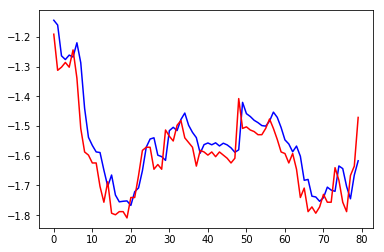

In [13]:
leng = len(y_test)
out1 = lstm(leng)
y_pre = sess.run([out1],feed_dict={xs:x_test})
x = np.arange(0,leng)
plt.plot(x,y_pre[0][0],'b',x,y_test,'r')